In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../data/feature-engineered/reg_df_reduced.csv')

0:	learn: 4.4775807	total: 62ms	remaining: 1m 1s
100:	learn: 1.5972655	total: 196ms	remaining: 1.74s
200:	learn: 1.1972675	total: 323ms	remaining: 1.28s
300:	learn: 0.9048815	total: 453ms	remaining: 1.05s
400:	learn: 0.6883192	total: 570ms	remaining: 851ms
500:	learn: 0.5442267	total: 685ms	remaining: 682ms
600:	learn: 0.4169016	total: 806ms	remaining: 535ms
700:	learn: 0.3413628	total: 921ms	remaining: 393ms
800:	learn: 0.2781921	total: 1.04s	remaining: 258ms
900:	learn: 0.2201869	total: 1.17s	remaining: 128ms
999:	learn: 0.1854048	total: 1.3s	remaining: 0us
0:	learn: 4.4762177	total: 2.61ms	remaining: 2.61s
100:	learn: 1.9406625	total: 124ms	remaining: 1.1s
200:	learn: 1.4613884	total: 242ms	remaining: 962ms
300:	learn: 1.0879014	total: 360ms	remaining: 835ms
400:	learn: 0.8336940	total: 502ms	remaining: 749ms
500:	learn: 0.6545101	total: 632ms	remaining: 629ms
600:	learn: 0.5097269	total: 753ms	remaining: 500ms
700:	learn: 0.4002240	total: 878ms	remaining: 375ms
800:	learn: 0.332313

/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/donaldaadithiyan/Personal learn dev/RecessionRadar/venv/l

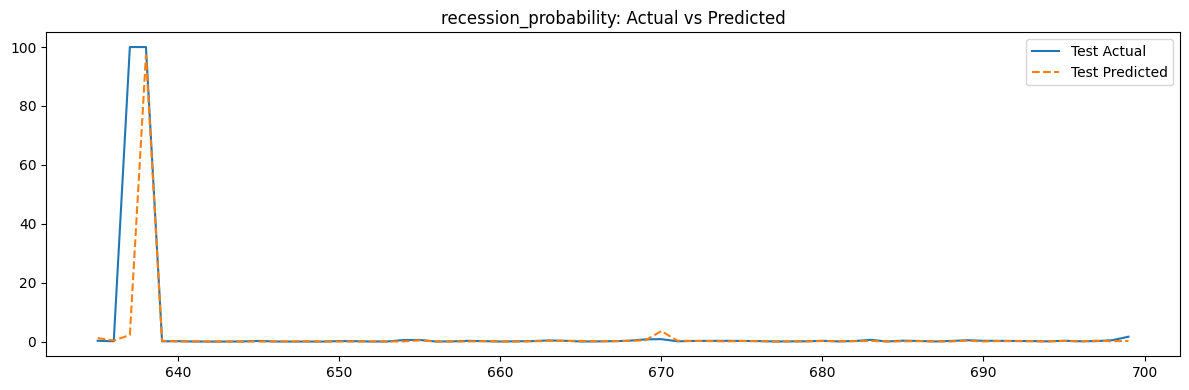

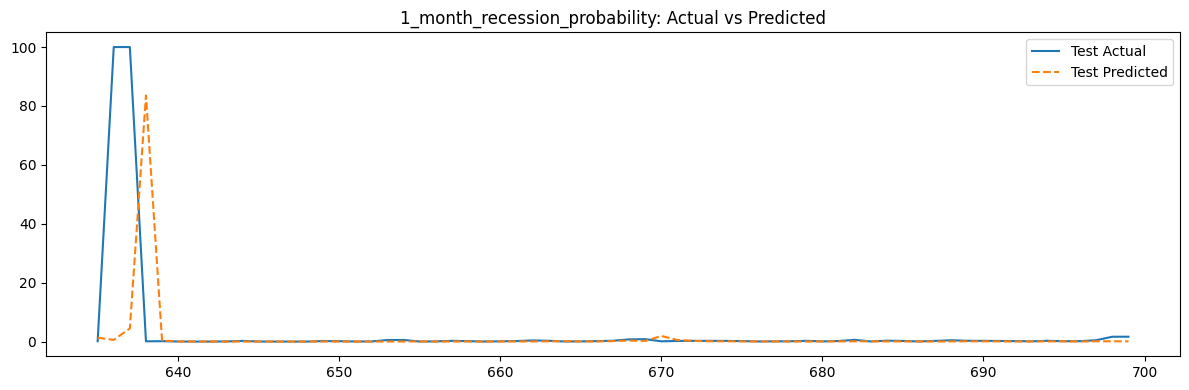

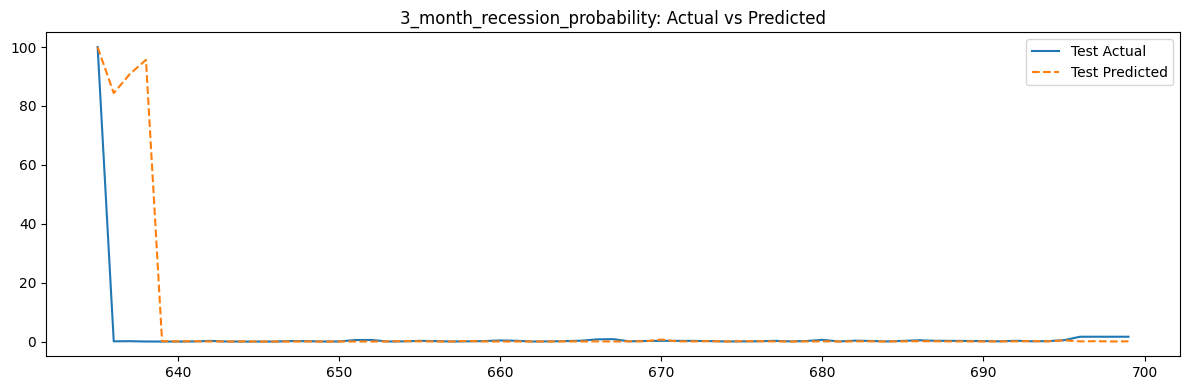

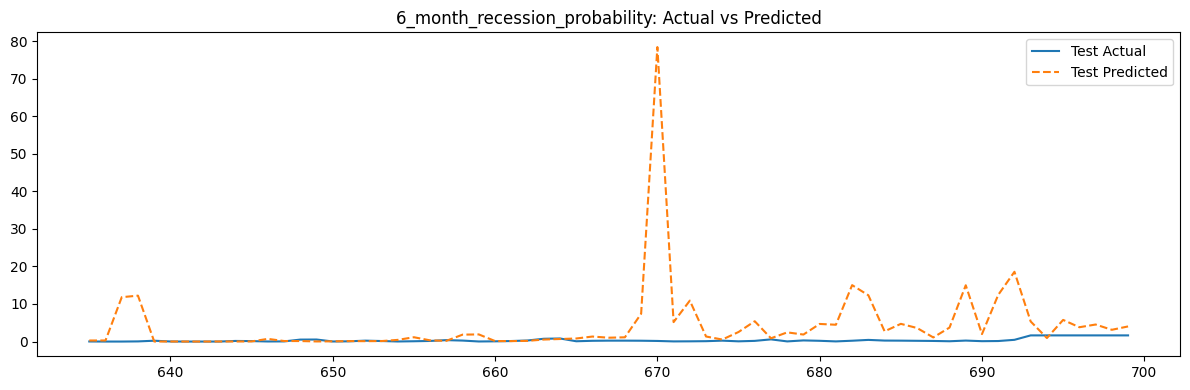

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
from sklearn.multioutput import RegressorChain
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------
# Key indicators (for reference)
# -------------------------
key_indicators = [
    '1_year_rate','3_months_rate','6_months_rate','CPI','INDPRO',
    '10_year_rate','share_price','unemployment_rate','PPI',
    'OECD_CLI_index','CSI_index','gdp_per_capita'
]

# -------------------------
# Targets
# -------------------------
recession_targets = [
    "recession_probability",
    "1_month_recession_probability",
    "3_month_recession_probability",
    "6_month_recession_probability",
]

# -------------------------
# Split train/test
# -------------------------
split_date = "2020-01-01"
df["date"] = pd.to_datetime(df["date"])
train_df = df[df["date"] < split_date].copy()
test_df  = df[df["date"] >= split_date].copy()

X_train = train_df.drop(columns=recession_targets + ["date"])
X_test  = test_df.drop(columns=recession_targets + ["date"])
y_train = train_df[recession_targets]
y_test  = test_df[recession_targets]

# -------------------------
# Clean NaNs
# -------------------------
def clean_data(X_or_y):
    X_or_y = X_or_y.replace([np.inf, -np.inf], np.nan)
    X_or_y = X_or_y.ffill().bfill()
    X_or_y = X_or_y.fillna(0)
    return X_or_y

X_train = clean_data(X_train)
X_test  = clean_data(X_test)
y_train = clean_data(y_train)
y_test  = clean_data(y_test)

# -------------------------
# Logit transform for [0,100] probabilities
# -------------------------
epsilon = 1e-6
def logit_transform(y):
    y_scaled = np.clip(y / 100, epsilon, 1 - epsilon)
    return np.log(y_scaled / (1 - y_scaled))

def inv_logit_transform(y_logit):
    y_prob = 1 / (1 + np.exp(-y_logit))
    return y_prob * 100

# -------------------------
# Step 1: RegressorChain for first 3 targets
# -------------------------
chain_targets = recession_targets[:3]

X_train_chain = X_train.copy()
X_test_chain  = X_test.copy()
y_train_chain = logit_transform(y_train[chain_targets].values)
y_test_chain  = y_test[chain_targets]

# CatBoost as base regressor
base_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    subsample=0.9,
    random_seed=42,
    loss_function="RMSE",
    verbose=100
)

chain_model = RegressorChain(base_model)
chain_model.fit(X_train_chain, y_train_chain)

# Predict first 3 targets and invert logit
preds_chain_logit = chain_model.predict(X_test_chain)
preds_chain_df = pd.DataFrame(
    inv_logit_transform(preds_chain_logit),
    columns=chain_targets,
    index=X_test.index
).clip(0, 100)

# -------------------------
# Step 2: Separate model for 6-month target
# -------------------------
target_6m = "6_month_recession_probability"

# Include predictions of first 3 targets as extra features
X_train_6m = X_train.copy()
X_train_6m[chain_targets] = inv_logit_transform(chain_model.predict(X_train_chain))
X_test_6m = X_test.copy()
X_test_6m[chain_targets] = preds_chain_df

y_train_6m = logit_transform(y_train[target_6m].values)
y_test_6m  = y_test[target_6m]

model_6m = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    subsample=0.9,
    random_seed=42,
    loss_function="RMSE",
    verbose=100
)

train_pool_6m = Pool(X_train_6m, y_train_6m)
test_pool_6m = Pool(X_test_6m)
model_6m.fit(train_pool_6m)

# Predict and invert logit
pred_6m = inv_logit_transform(model_6m.predict(test_pool_6m)).clip(0, 100)

# -------------------------
# Combine all predictions
# -------------------------
preds_test_final = preds_chain_df.copy()
preds_test_final[target_6m] = pred_6m

# -------------------------
# Evaluate
# -------------------------
def evaluate(y_true, y_pred, dataset_name="Dataset"):
    print(f"\n=== Evaluation on {dataset_name} ===")
    for target in recession_targets:
        mae = mean_absolute_error(y_true[target], y_pred[target])
        rmse = mean_squared_error(y_true[target], y_pred[target], squared=False)
        r2 = r2_score(y_true[target], y_pred[target])
        print(f"{target}: MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")

evaluate(y_test, preds_test_final, "Test")

# -------------------------
# Plot Actual vs Predicted
# -------------------------
for target in recession_targets:
    plt.figure(figsize=(12, 4))
    plt.plot(test_df.index, y_test[target], label="Test Actual")
    plt.plot(test_df.index, preds_test_final[target], label="Test Predicted", linestyle="--")
    plt.title(f"{target}: Actual vs Predicted")
    plt.legend()
    plt.tight_layout()
    plt.show()
